In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot


import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

## Make data

In [2]:

n_verts = 100
labels_sbm = n_verts * [0] + n_verts * [1]
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])

# Generate SBMs from parameters
undirected_sbm = sbm(2 * [n_verts], P)
directed_sbm = sbm(2 * [n_verts], P, directed=True)

## Using graspologic ZG(2) method
I am a little confused as to whether this is ZG(1) or ZG(2). I think it is ZG(2) because we get two elbow estimations. 

In [3]:
from graspologic.embed import select_dimension
select_dimension(undirected_sbm)

([2, 4], [60.040654885507344, 11.571250884605346])

## Example use of using sklean minka estimation

In [4]:
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg
X = undirected_sbm.copy()
n_components = 'mle'
n_samples = X.shape[0]
# Center data
mean_ = np.mean(X, axis=0)
X -= mean_

U, S, Vt = linalg.svd(X, full_matrices=False)
# flip eigenvectors' sign to enforce deterministic output
U, Vt = svd_flip(U, Vt)

components_ = Vt

# Get variance explained by singular values
explained_variance_ = (S ** 2) / (n_samples - 1)
total_var = explained_variance_.sum()
explained_variance_ratio_ = explained_variance_ / total_var
singular_values_ = S.copy()  # Store the singular values.

# Postprocess the number of components required
if n_components == 'mle':
    n_components = \
        _infer_dimension(explained_variance_, n_samples)

In [5]:
n_components

2

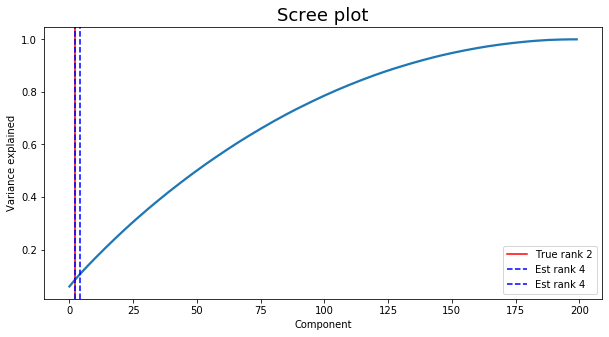

In [13]:
from graspologic.plot import screeplot
screeplot(X)
plt.axvline(2, label='True rank {}'.format(2), color='red')
plt.axvline(4, label='Est rank {}'.format(4), color='blue', ls='--')
plt.axvline(2, label='Est rank {}'.format(4), color='blue', ls='--')
plt.legend()

In [21]:
S[4]

10.953765002590819

In [32]:
import scipy
D = scipy.sparse.linalg.svds(A=X, k=X.shape[0] - 1, return_singular_vectors=False)

0.19249476333055776